In [2]:
!pip install tqdm  >> /dev/null
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from bert import tokenization
from tqdm import tqdm_notebook

2.2.0-rc2


In [3]:
from google.colab import files
uploaded = files.upload()

Saving cleaned.csv to cleaned.csv


In [4]:
import pandas as pd
df = pd.read_csv('cleaned.csv')
df.head()

,keywords,label
0,sterilization vas fertile male bilateral ...,urology
1,prostate cancer technetium whole body uri...,urology
2,vasectomy allis clamp catgut hemoclips i...,urology
3,hemiscrotum bilateral vasectomy voluntary ...,urology
4,scrotal incision right vas bleeding anest...,urology


In [5]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


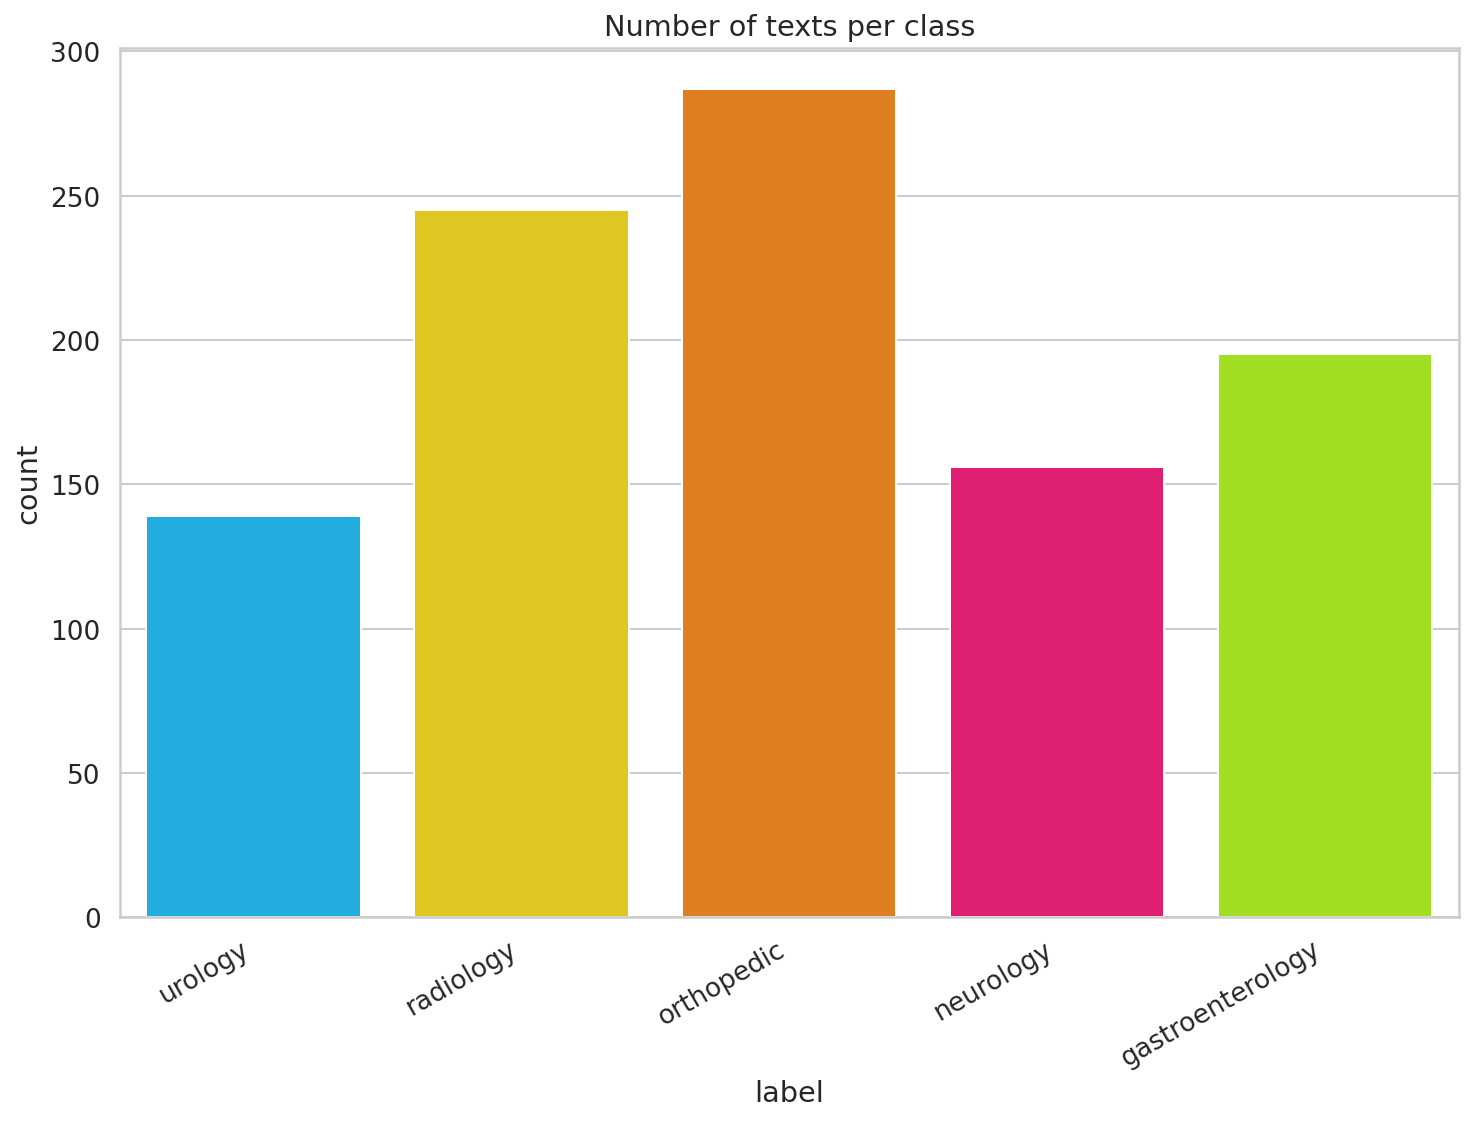

In [6]:
chart = sns.countplot(df.label)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [7]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-04-05 04:31:17--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   168MB/s    in 2.3s    

2020-04-05 04:31:19 (168 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [8]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs("model", exist_ok=True)

In [0]:
!mv uncased_L-12_H-768_A-12/ model

In [0]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [0]:
class PrescriptionClassification:
  DATA_COLUMN = "keywords"
  LABEL_COLUMN = "label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=256):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[PrescriptionClassification.DATA_COLUMN], row[PrescriptionClassification.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [14]:
df.loc[50].keywords

'  scrotum  hemostasis  marcaine  catgut  incision  scrotal orchiectomy  spermatic cord  sterile dressing  testicle  transverse  suture ligated  chromic catgut  orchiectomy  scrotal  cordnote  thesetranscribed medical transcription sample reports and examples are provided by various users andare for reference purpose only mthelpline does not certify accuracy and quality of sample reportsthese transcribed medical transcription sample reports may include some uncommon or unusual formats this would be due to the preference of the dictating physician all names and dates have beenchanged  or removed  to keep confidentiality any resemblance of any type of name or date orplace or anything else to real world is purely incidental'

In [15]:
tokenizer.tokenize(df.loc[50].keywords)

['sc',
 '##rot',
 '##um',
 'hem',
 '##osta',
 '##sis',
 'marc',
 '##aine',
 'cat',
 '##gut',
 'inc',
 '##ision',
 'sc',
 '##rot',
 '##al',
 'or',
 '##chi',
 '##ect',
 '##omy',
 'sperm',
 '##atic',
 'cord',
 'sterile',
 'dressing',
 'test',
 '##icle',
 'transverse',
 'su',
 '##ture',
 'liga',
 '##ted',
 'ch',
 '##rom',
 '##ic',
 'cat',
 '##gut',
 'or',
 '##chi',
 '##ect',
 '##omy',
 'sc',
 '##rot',
 '##al',
 'cord',
 '##note',
 'these',
 '##tra',
 '##ns',
 '##cr',
 '##ibe',
 '##d',
 'medical',
 'transcription',
 'sample',
 'reports',
 'and',
 'examples',
 'are',
 'provided',
 'by',
 'various',
 'users',
 'and',
 '##are',
 'for',
 'reference',
 'purpose',
 'only',
 'mt',
 '##hel',
 '##plin',
 '##e',
 'does',
 'not',
 'ce',
 '##rti',
 '##fy',
 'accuracy',
 'and',
 'quality',
 'of',
 'sample',
 'reports',
 '##thes',
 '##e',
 'transcribed',
 'medical',
 'transcription',
 'sample',
 'reports',
 'may',
 'include',
 'some',
 'uncommon',
 'or',
 'unusual',
 'formats',
 'this',
 'would',
 'be',


In [0]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=64, activation="relu")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [17]:
df = df.sample(frac=1)
classes = df.label.unique().tolist()

data = PrescriptionClassification(df[:int(len(df)*.8)], df[int(len(df)*.8):], tokenizer, classes, max_seq_len=190)

817it [00:00, 1172.98it/s]
205it [00:00, 1281.59it/s]

max seq_len 190


In [18]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 190, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fb78e318cc0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 190)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 190, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                49216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325   

In [0]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [21]:
log_dir = "log/prescription_classification/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=10,
  verbose = 1,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
23/23 [==============================] - 1425s 62s/step - loss: 1.5960 - acc: 0.2653 - val_loss: 1.5104 - val_acc: 0.4146
Epoch 2/10
23/23 [==============================] - 1420s 62s/step - loss: 1.5721 - acc: 0.2952 - val_loss: 1.4847 - val_acc: 0.4634
Epoch 3/10
23/23 [==============================] - 1426s 62s/step - loss: 1.5287 - acc: 0.3429 - val_loss: 1.4020 - val_acc: 0.5488
Epoch 4/10
23/23 [==============================] - 1429s 62s/step - loss: 1.4583 - acc: 0.4354 - val_loss: 1.2649 - val_acc: 0.6951
Epoch 5/10
23/23 [==============================] - 1434s 62s/step - loss: 1.3896 - acc: 0.5293 - val_loss: 1.2318 - val_acc: 0.6829
Epoch 6/10
23/23 [==============================] - 1438s 63s/step - loss: 1.3355 - acc: 0.5741 - val_loss: 1.1909 - val_acc: 0.7073
Epoch 7/10
23/23 [==============================] - 1436s 62s/step - loss: 1.3004 - acc: 0.6027 - val_loss: 1.1931 - val_acc: 0.7073
Epoch 8/10
23/23 [==============================] - 1430s 62s/step - 

In [22]:
log_dir = "log/prescription_classification/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=10,
  verbose = 1,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
23/23 [==============================] - 1430s 62s/step - loss: 1.0934 - acc: 0.8245 - val_loss: 1.0849 - val_acc: 0.8537
Epoch 2/10
23/23 [==============================] - 1429s 62s/step - loss: 1.0700 - acc: 0.8558 - val_loss: 1.1071 - val_acc: 0.8171
Epoch 3/10
23/23 [==============================] - 1429s 62s/step - loss: 1.0362 - acc: 0.8816 - val_loss: 1.0852 - val_acc: 0.8415
Epoch 4/10
23/23 [==============================] - 1425s 62s/step - loss: 1.0293 - acc: 0.8871 - val_loss: 1.0866 - val_acc: 0.8415
Epoch 5/10
23/23 [==============================] - 1439s 63s/step - loss: 1.0192 - acc: 0.8952 - val_loss: 1.0959 - val_acc: 0.8171
Epoch 6/10
23/23 [==============================] - 1443s 63s/step - loss: 1.0198 - acc: 0.8884 - val_loss: 1.0707 - val_acc: 0.8537
Epoch 7/10
23/23 [==============================] - 1434s 62s/step - loss: 1.0169 - acc: 0.9007 - val_loss: 1.0817 - val_acc: 0.8415
Epoch 8/10
23/23 [==============================] - 1434s 62s/step - 

In [0]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [25]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        33
           1       0.82      0.93      0.87        59
           2       0.98      1.00      0.99        40
           3       0.90      0.81      0.85        32
           4       0.71      0.61      0.66        41

    accuracy                           0.84       205
   macro avg       0.85      0.83      0.84       205
weighted avg       0.84      0.84      0.84       205



In [26]:
confusion_matrix(data.test_y, y_pred)

array([[27,  1,  0,  2,  3],
       [ 0, 55,  1,  0,  3],
       [ 0,  0, 40,  0,  0],
       [ 1,  1,  0, 26,  4],
       [ 5, 10,  0,  1, 25]])

In [32]:

print(classes.index('neurology'))
print(classes.index('gastroenterology'))
print(classes.index('urology'))
print(classes.index('radiology'))
print(classes.index('orthopedic'))

2
0
3
4
1


In [38]:
keywords = [
  "prostate cancer  technetium  whole body  urinary retention", #urology
  " reconstruction  appendicitis  urinary tract infection  ct abdomen  abdomen  ct  pelvis  contrast  noncontrast", #radiology
  "peritoneal cavity  peritoneal fluid  abdominal cavity  abdominis muscle  transversalis fascia  peritoneum  internal oblique fascia  vicryl ties", #gasteronology
  "transpedicular  vertebroplasty  fluoroscopic views  fluoroscopic images  epidural space  compression fracture  vertebral body  compression  pedicle  fluoroscopic  vertebral  needle " #orthopedic
]

pred_tokens = map(tokenizer.tokenize, keywords)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(keywords, predictions):
  print("text:", text, "\nspecialty:", classes[label])
  print()

text: prostate cancer  technetium  whole body  urinary retention 
specialty: urology

text:  reconstruction  appendicitis  urinary tract infection  ct abdomen  abdomen  ct  pelvis  contrast  noncontrast 
specialty: gastroenterology

text: peritoneal cavity  peritoneal fluid  abdominal cavity  abdominis muscle  transversalis fascia  peritoneum  internal oblique fascia  vicryl ties 
specialty: gastroenterology

text: transpedicular  vertebroplasty  fluoroscopic views  fluoroscopic images  epidural space  compression fracture  vertebral body  compression  pedicle  fluoroscopic  vertebral  needle  
specialty: orthopedic



In [1]:
#3 right 1 wrong

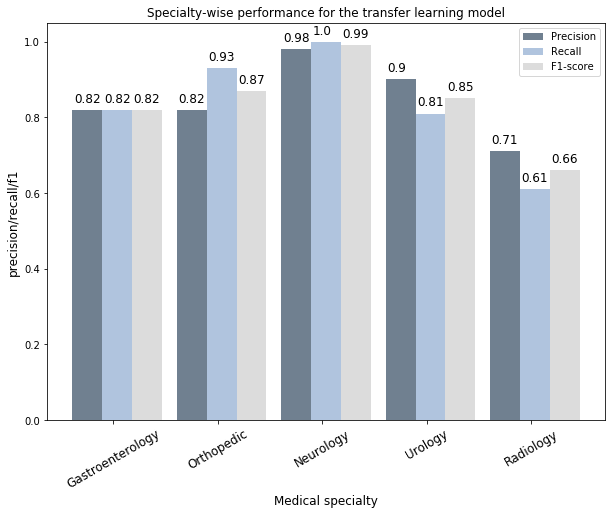

In [4]:
import matplotlib.pyplot as plt
label = ['Gastroenterology', 'Orthopedic', 'Neurology','Urology' , 'Radiology',
       ]
# Create bars
barWidth = 2
bars1 = [0.82, 0.82, 0.98, 0.90, 0.71]
bars2 = [0.82, 0.93, 1.0, 0.81 ,0.61]
bars3 = [0.82 , 0.87, 0.99, 0.85, 0.66]
bars4 = bars1 + bars2 + bars3
 
# The X position of bars
r1 = [1,8,15, 22, 29]
r2 = [3,10,17, 24, 31]
r3 = [5,12,19,26,33]
r4 = r1 + r2 + r3
 
plt.figure(figsize=(10, 1.2))
# Create barplot
plt.bar(r1, bars1, width = barWidth, color = 'slategrey', label='Precision')
plt.bar(r2, bars2, width = barWidth, color = 'lightsteelblue', label='Recall')
plt.bar(r3, bars3, width = barWidth, color = 'gainsboro', label='F1-score')
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend()
plt.xlabel('Medical specialty', fontsize=12)
plt.ylabel('precision/recall/f1', fontsize=12)
 
# Text below each barplot with a rotation at 90°
#plt.xticks([r + barWidth for r in range(len(r4)/3)], ['DD', 'with himself', 'with DC', 'with Silur', 'DC'], rotation=90)
 
# Create labels
labels = bars4
 
# Text on the top of each barplot
for i in range(len(r4)):
    plt.text(x = r4[i]-0.9 , y = bars4[i]+0.02, s = labels[i], size = 12, rotation = 0)
 
# Adjust the margins
plt.subplots_adjust(bottom=1, top = 5.6)
#X = np.arange(15)
plt.xticks([2.75, 9.75, 16.75, 23.75, 30.75], label, fontsize=12, rotation=30)
plt.title('Specialty-wise performance for the transfer learning model')
# Show graphic
plt.show()